In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc
import tempfile

import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

## toy ABC

The ABC results I showed in class are too compute-heavy to be "notebookable," so I thought I would walk through a toy version as a demonstration.
Everything here is pretty much the same except we'll generate less samples per generation, and run for fewer generations, so the constraints won't be quite as good.

#### functions

Gathered from various other scripts!

In [3]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)
    return np.array([x, y, z])

def dipole(theta, phi, dipole_x, dipole_y, dipole_z):
    """
    Return the signal contribution from the dipole at a certain sky location (theta,phi).
    """
    return dipole_x*np.sin(theta)*np.cos(phi) + dipole_y*np.sin(theta)*np.sin(phi) + dipole_z*np.cos(theta)

In [4]:
# plotting things
def get_kde_1d(history, prior, parameter):

    df, w = history if type(history) == list else history.get_distribution()
    return pyabc.visualization.kde.kde_1d(pd.concat((df[parameter],), axis=1), w, df[parameter].name,
                           xmin=prior[parameter].args[0],
                           xmax=prior[parameter].args[0] + prior[parameter].args[1])
    
def get_kde_2d(history, prior, parameter1, parameter2):

    df, w = history if type(history) == list else history.get_distribution()
    return pyabc.visualization.kde.kde_2d(pd.concat((df[parameter1], df[parameter2]), axis=1), w, df[parameter1].name, df[parameter2].name,
                            xmin=prior[parameter1].args[0],
                            xmax=prior[parameter1].args[0] + prior[parameter1].args[1],
                            ymin=prior[parameter2].args[0],
                            ymax=prior[parameter2].args[0] + prior[parameter2].args[1])


def scatter(history, prior, parameter1, parameter2, ax, **kwargs):

    df, w = history if type(history) == list else history.get_distribution()
    ax.scatter(df[parameter1], df[parameter2], **kwargs)
    ax.set_xlim(prior[parameter1].args[0],
                prior[parameter1].args[0] + prior[parameter1].args[1])
    ax.set_ylim(prior[parameter2].args[0],
                prior[parameter2].args[0] + prior[parameter2].args[1])

In [5]:
def omega_to_theta(omega):
    """
    Convert solid angle omega in steradians to theta in radians for
    a cone section of a sphere.
    """
    return np.arccos(1 - omega / (2 * np.pi)) * u.rad
    
def smooth_map(density_map, sr=1, verbose=True):

    theta = omega_to_theta(sr)  # convert steradians to angle on the sky

    NPIX = len(density_map)
    lon, lat = hp.pix2ang(hp.npix2nside(NPIX), np.arange(NPIX), lonlat=True)
    sc = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs')

    # initial column
    smoothed_map = -1 * np.ones(NPIX)
    for i, denspix in enumerate(density_map):
        if np.isnan(denspix):
            smoothed_map[i] = np.nan
        else:
            d2d = sc[i].separation(sc)
            mask = d2d < theta
            smoothed_map[i] = np.nanmean(density_map[mask])
        if verbose:
            print("%.1f%%" % ((i + 1) / NPIX * 100), end='\r')

    return smoothed_map

#### the "observation"

Here we construct the "observation," though in this case we just generate it with the same forward model that we use in the ABC.
This is an important validation step for the parameter inference in order to trust the results with the real quasar map!

In [6]:
def model(parameters, selfunc, base_rate, dipdir, theta, phi,
          ell_max=8, poisson=True,
          excess_dipole_comps=None,
          return_alms=False):
    """
    Generates a healpix density map with dipole in fixed CMB dipole direction and excess angular power.
    Uses fiducial selection function (Quaia + galactic plane mask + smaller masks from S21).

    Parameters
    ----------
    parameters : dict
        keys:
            "dipole_amp" = dipole amplitude
            "log_excess" = log of the excess power (flat in Cell)
    selfunc : 1D array
        Selection function map. The map is generated with the same npix.
    base_rate : float
        Base rate (used to be a parameter, now hard-coded).
    dipdir : astropy SkyCoord
        Kinematic dipole direction.
    theta, phi : array-like
        Sky coordinates (theta, phi) of each healpixel.
    ell_max : int, optional
        Maximum multipole at which to add excess angular power.
    poisson : bool, optional
        Whether to add Poisson noise to the maps (using `base_rate`).
    excess_dipole_comps : array-like (len 3) or None, optional
        Optionally input a set of three orthogonal dipole amplitudes to specify the amplitude and direction of
        the "excess dipole." If `None`, uses `parameters['log_excess']` to draw random a1ms (like the other alms).
    return_alms : bool, optional (default True)
        Whether to return the alms drawn at random from the Cells.

    Returns
    -------
    Quasar number map.
    
    """

    nside = hp.npix2nside(len(selfunc))

    # expected dipole map
    amps = spherical_to_cartesian(r=parameters["dipole_amp"],
                                        theta=np.pi/2-dipdir.icrs.dec.rad,
                                        phi=dipdir.icrs.ra.rad)
    expected_dipole_map = dipole(theta, phi, *amps)

    # excess power:
    excess_map = np.zeros_like(expected_dipole_map)
    if parameters["log_excess"] > -20:  # magic, kind of hacky but I want a way to have literally zero excess power
        if excess_dipole_comps is not None:
            assert len(excess_dipole_comps) == 3, "must input three dipole amplitudes (m=-1, 0, 1)"
            excess_map += dipole(theta, phi, *excess_dipole_comps)

            # then just add power in Cells starting at ell=2
            Cells = np.zeros(ell_max + 1)
            Cells[2:] += 10**parameters["log_excess"]
        else:
            # otherwise just add Cells like normal: flat, determined by input log_excess (and maybe input_a1ms)
            Cells = np.zeros(ell_max + 1)
            Cells[1:] += 10**parameters["log_excess"]   # because we don't want excess power in the monopole
        
        # generate excess power in the map by randomly drawing alms from the Cell spectrum
        if return_alms == True:
            excess_map_, alms = hp.sphtfunc.synfast(Cells, nside, alm=True)
            excess_map += excess_map_
        else:
            excess_map += hp.sphtfunc.synfast(Cells, nside)

    # smooth overdensity map
    smooth_overdensity_map = expected_dipole_map + excess_map

    # poisson sample, including the base rate and the selfunc map
    number_map = (1. + smooth_overdensity_map) * base_rate * selfunc
    if poisson == True:
        rng = np.random.default_rng(seed=None) # should I put a seed in here??
        number_map = rng.poisson(number_map)

    res = { "data" : number_map }

    if return_alms == True:
        res["alms"] = alms
    if excess_dipole_comps is not None:
        res["excess_dipole_comps"] = excess_dipole_comps

    return res

In [7]:
# generate the "observation"
nside = 64
ell_max = 8
expected_dipole_amp = 0.0052
log_excess = -7
base_rate = 33.6330  # mean base rate of the final 100 accepted samples for Quaia, 14 generations
poisson = True
# selection function: for this toy case, say we have perfect completeness!
selfunc = np.ones(hp.nside2npix(nside))

# expected dipole direction
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')

# (theta, phi) in each healpixel
theta, phi = hp.pix2ang(nside, ipix=np.arange(hp.nside2npix(nside)))

data_pars = dict(dipole_amp=expected_dipole_amp, log_excess=log_excess)
data = model(data_pars, selfunc, base_rate, cmb_dipdir, theta, phi, ell_max, poisson=poisson, return_alms=True)

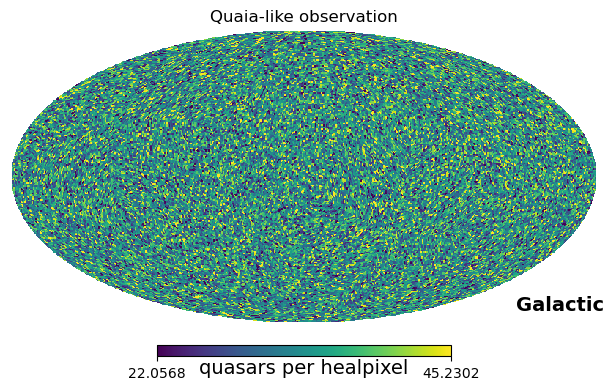

In [8]:
# plot
fig = plt.figure(figsize=(12,4))
mean, std = np.nanmean(data['data']), np.nanstd(data['data'])
hp.mollview(data['data'], coord=['C','G'], min=mean-2*std, max=mean+2*std,
            sub=(1,2,1), fig=fig, title='Quaia-like observation', unit='quasars per healpixel')

This just looks like noise! But I swear there is a kinematic dipole + excess angular power in there...

#### perform the sampling!

In [9]:
# input parameters
distance_nside = 1
population_size = 100
ngens = 5

In [10]:
# convert the observation to overdensity: this is how we want to compare the data
odmap = data['data'] / np.nanmean(data['data']) - 1.

In [11]:
# prior: flat
dipole_amp_bounds = (0., 3. * expected_dipole_amp)
log_excess_bounds = (-9, 4)
prior = pyabc.Distribution(dipole_amp = pyabc.RV("uniform", *dipole_amp_bounds),
                           log_excess = pyabc.RV("uniform", *log_excess_bounds))

In [12]:
# distance metric
def distance(x, x0):
    """
    Distance function to evaluate acceptance or rejection of mocks.

    Parameters
    ----------
    x : shape (npix,)
        Mock quasar map.
    x0 : shape (npix,)
        Data; real quasar map.
    
    Returns
    -------
    rho : float
        Sum of the difference in the _overdensity_ pixel values squared.
    """

    # convert mock counts to overdensity
    odmap_mock = x['data'] / np.nanmean(x['data']) - 1.

    return np.sum(hp.ud_grade(odmap_mock - x0['data'], distance_nside)**2)

In [13]:
# create a wrapper function for the model: need this in order to match required format for pyabc
def model_wrapper(parameters):
    return model(parameters, selfunc, base_rate, cmb_dipdir, theta, phi, ell_max, poisson=poisson)

In [14]:
# instantiate the AMCSMC object
abc = pyabc.ABCSMC(model_wrapper, prior, distance, population_size=population_size)
observation = odmap   # the true data _overdensity_

# store the history at this tempfile
db_path = os.path.join(tempfile.gettempdir(), f'history.db')
abc.new("sqlite:///" + db_path, {"data": observation})

# start the sampling!
history = abc.run(max_nr_populations=ngens)

ABC.Sampler INFO: Parallelize sampling on 48 processes.
ABC.History INFO: Start <ABCSMC id=4, start_time=2025-03-07 22:45:51>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.96321162e-04.
ABC INFO: Accepted: 100 / 186 = 5.3763e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.23928623e-04.
ABC INFO: Accepted: 100 / 294 = 3.4014e-01, ESS: 8.9286e+01.
ABC INFO: t: 2, eps: 9.56947726e-05.
ABC INFO: Accepted: 100 / 487 = 2.0534e-01, ESS: 9.2149e+01.
ABC INFO: t: 3, eps: 7.61019573e-05.
ABC INFO: Accepted: 100 / 752 = 1.3298e-01, ESS: 7.8550e+01.
ABC INFO: t: 4, eps: 6.32500532e-05.
ABC INFO: Accepted: 100 / 1289 = 7.7580e-02, ESS: 7.9557e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=4, duration=0:00:48.867332, end_time=2025-03-07 22:46:40>


#### results

Text(0.5, 0.98, 'ABC posteriors, fake Quaia, nside=1, 5 generations, 100 mocks per generation')

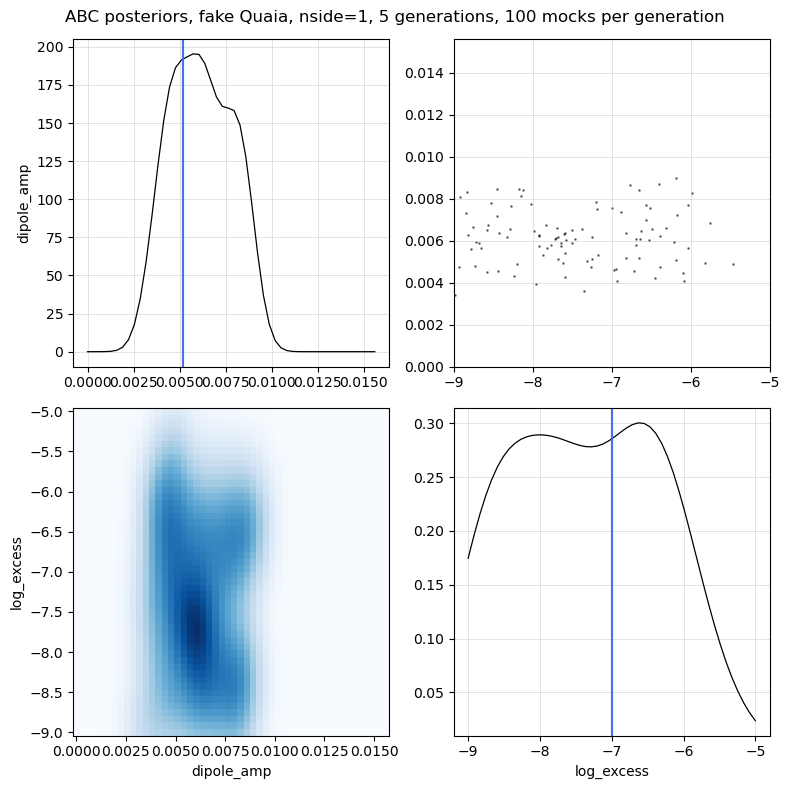

In [15]:
# plot the posteriors

par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(8,8), tight_layout=True)

for i, par_id in enumerate(par_ids):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_id)
    ax.plot(x, pdf, c='k', alpha=1., lw=0.9)
    if par_id == 'dipole_amp':
        ax.axvline(expected_dipole_amp, c='royalblue', alpha=0.8)
    if par_id == 'log_excess':
        ax.axvline(log_excess, c='royalblue', alpha=0.8)
    ax.grid(alpha=0.5, lw=0.5)
    ax.axvline(data_pars[par_id], c='royalblue', alpha=0.7)

    axs[i,0].set_ylabel(par_id)
    axs[len(par_ids)-1,i].set_xlabel(par_id)

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='Blues')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)
    
fig.suptitle(f'ABC posteriors, fake Quaia, nside={distance_nside}, {ngens} generations, {population_size} mocks per generation')

We recover the inputs pretty well!

In [17]:
df, w = history.get_distribution()
print(f"median posterior dipole amplitude\t=\t{np.median(df['dipole_amp']):.5f}")
print(f"median posterior log excess power\t=\t{np.median(df['log_excess']):.3f}")

median posterior dipole amplitude	=	0.00610
median posterior log excess power	=	-7.586


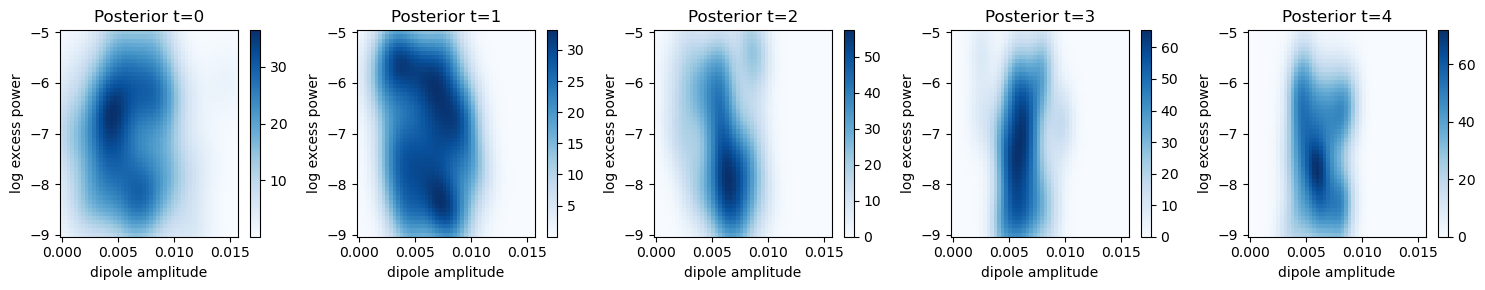

In [18]:
# and we can check out the evolution of the posterior
fig = plt.figure(figsize=(15, 3), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot((history.max_t + 1) // 3, 5, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'].args[0],
        xmax=prior['dipole_amp'].args[0] + prior['dipole_amp'].args[1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'].args[0],
        ymax=prior['log_excess'].args[0] + prior['log_excess'].args[1],
        ax=ax,
        cmap='Blues'
    )
    ax.set_title(f"Posterior t={t}")

We can see that the posterior gets tighter each generation, as the particle weights get updated.

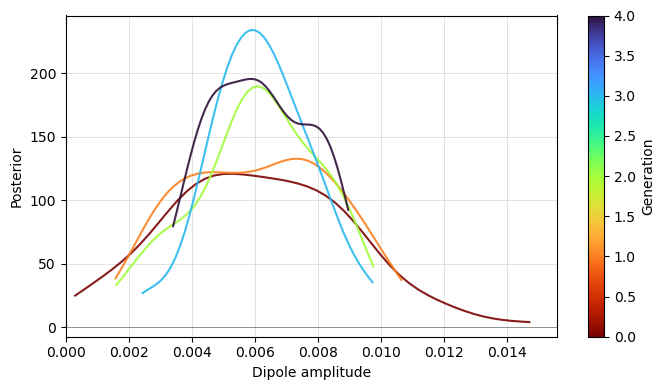

In [19]:
# check how the dipole amplitude evolves
fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo_r')
for i in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(history, "dipole_amp", t=i, ax=ax, color=smap.to_rgba(i), alpha=0.9)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Dipole amplitude')
ax.set_xlim(prior['dipole_amp'].args)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='Generation')

Text(0, 0.5, 'Acceptance threshold $\\varepsilon$ (1e-4)')

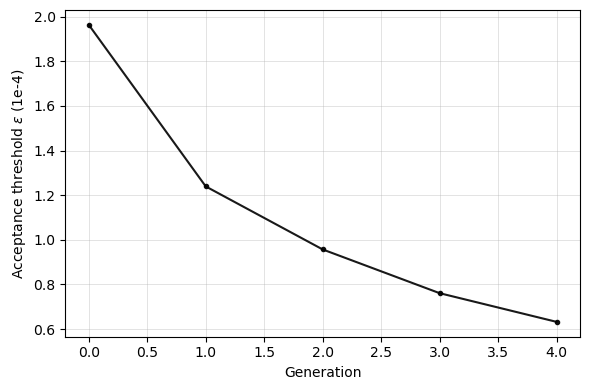

In [20]:
# and how the acceptance threshold evolves
# note: first entry is from calibration and thus translates to inf, thus must be discarded
eps = np.array(history.get_all_populations()['epsilon'][1:])

fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(eps * 1e4, c='k', marker='.', alpha=0.9)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Generation')
ax.set_ylabel(r'Acceptance threshold $\varepsilon$ (1e-4)')

In [21]:
# finally, we can look at the posterior mocks and compare them to the input observation
pop = history.get_population()
posterior_mocks = [
    particle.sum_stat['data'] for particle in pop.particles
]

mean_posterior_mock = np.mean(posterior_mocks, axis=0)

In [22]:
# smooth the input observation to reduce the noise
smoothed_data = smooth_map(data['data'], sr=1)

In [23]:
# and the mean posterior mock
smoothed_posterior = smooth_map(mean_posterior_mock, sr=1)

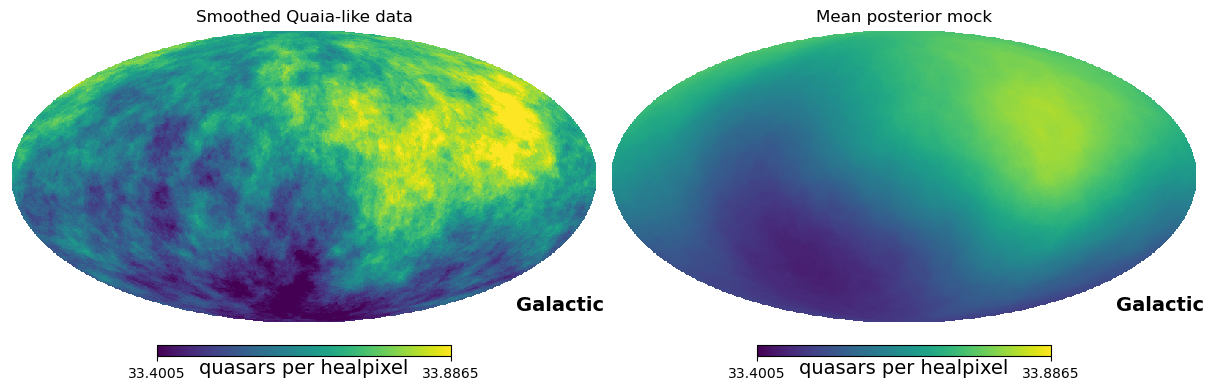

In [24]:
fig = plt.figure(figsize=(12,4))

mean, std = np.nanmean(smoothed_data), np.nanstd(smoothed_data)
kwargs = dict(coord=['C','G'], min=mean-2*std, max=mean+2*std, unit='quasars per healpixel', fig=fig)
hp.mollview(smoothed_data, sub=(1,2,1), title='Smoothed Quaia-like data', **kwargs)
hp.mollview(smoothed_posterior, sub=(1,2,2), title='Mean posterior mock', **kwargs)

Even with this small number of generations, we generally match the over- and under-densities found in the data!